Model inspired by https://arxiv.org/pdf/2103.05940  

In [ ]:
#upload python file here
from google.colab import files
files.upload()

Saving data_loading.py to data_loading.py


{'data_loading.py': b'# load the three datasets 128x128 with labels \nimport numpy as np \nimport gdown\nimport zipfile \n\n\ndef download_data():\n    \n    # download and unzip the clean data \n    file_id = \'1Gf532J0NEthwhg0k20oC7lJforGkmklx\'\n    url = f\'https://drive.google.com/uc?id={file_id}\'   \n    gdown.download(url, \'data_zipped\', quiet=False) \n    with zipfile.ZipFile(\'data_zipped\', \'r\') as zipped_ref:\n            zipped_ref.extractall(\'data_unzipped\')\n\ndef get_data_unbalanced():\n    # load data\n    poland_images = np.load("/content/data_unzipped/Datasets/BrEaST Lesions - Breast Ultrasound 128x128/Poland_Medical_Centers_US_Breast_Images.npy")\n    poland_labels = np.load("/content/data_unzipped/Datasets/BrEaST Lesions - Breast Ultrasound 128x128/Poland_Medical_Centers_US_Breast_Labels.npy")\n\n    china_images = np.load("/content/data_unzipped/Datasets/Chinese Hospitals - Kidney Ultrasound 128x128/Chinese Hospitals_Kidney_US_Images.npy")\n    china_labels 

In [ ]:
# get all our data from helper
from data_loading import get_data_BIG_WGAN
(poland_images, poland_labels), (china_images, china_labels), (egypt_images, egypt_labels), (egypt_mixed_images_1180, egypt_mixed_labels_1180), (egypt_mixed_images_2360, egypt_mixed_labels_2360) = get_data_BIG_WGAN()

downloading a file with egypt 1180 samples (Main + BIG-WGAN) and poland, china


Downloading...
From (original): https://drive.google.com/uc?id=1PY29AhKzMo_msc0-8nc0oXnyWQHpbjWO
From (redirected): https://drive.google.com/uc?id=1PY29AhKzMo_msc0-8nc0oXnyWQHpbjWO&confirm=t&uuid=c8af960e-78d9-474b-b4a2-04967dde089c
To: /content/data_zipped
100%|██████████| 47.6M/47.6M [00:01<00:00, 46.4MB/s]


Poland: images (256, 128, 128), labels (256,)
China: images (635, 128, 128), labels (635,)
Egypt: images (780, 128, 128), labels (780,)
unbalanced, unshuffled,
0 for malignant, 1 for benign,
Poland label distribution:
  Label 0: 102
  Label 1: 154

China label distribution:
  Label 0: 435
  Label 1: 200

Egypt label distribution:
  Label 0: 210
  Label 1: 570

Egypt mixed with GAN:
  Label 0: 410
  Label 1: 770

Egypt mixed with GAN and FLIPPED:
  Label 0: 820
  Label 1: 1540
returns poland images(TEST THIS), china images, egypt images, egypt mixed images 1180(TRAIN THIS), egypt mixed images 2360(TRAIN THIS)


In [ ]:
#get libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

1x128x128 - > 256 x 32 x 32

In [ ]:
# The CNN part of the CNN-Transformer, the encoded features will move to the transformer, but we need to set up first.
class CNN(nn.Module):
    def __init__(self, in_channels=1, feature_dim=256, dropout_prob=0.1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),   # 1x128x128 IN
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
            nn.MaxPool2d(2),  # -> 64x64x64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
            nn.MaxPool2d(2),  # -> 128x32x32

            nn.Conv2d(128, feature_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
            # -> 256x32x32 OUT
        )

    def forward(self, x):
        return self.features(x)

Batch x 256 x 32 x 32  --- (flatten) ---> Batch x 256 x 1024 ----(permute) ---> Batch x 1024 x 256  
permute to fit into the positional embeddings 1 x 1024 x 256


In [ ]:
# Transformer part of the CNN-Transformer, learning is done of 256 features of 1024 patches and how they relate
class Transformer(nn.Module):
  def __init__(self, feature_dim = 256, num_patches = 32 * 32, layers =6, heads=8): # 256x32x32 IN from the CNN, number of patches is very large here (big amount of tokens), hopefully training does not take forever.
    super(Transformer, self).__init__()
    self.pos_embeddings = nn.Parameter(torch.randn(1, num_patches, feature_dim))  # pos embeddings of randomized tensor of dimensions 256 features x 1024 patches
    encoder_layer = nn.TransformerEncoderLayer(     # build the transformer network
        d_model=feature_dim,  # 256 features into the transformer
        nhead=heads,  # 8 heads
        dim_feedforward= 512, # 64x8 = 512 multi-head concatenated output
        dropout=0.1,  # regulraization
        batch_first=True
    )
    self.transformers = nn.TransformerEncoder(encoder_layer, num_layers=layers) # 6 layers of 8 heads each


  def forward(self, x):
    B, C, H, W = x.shape
    x = x.flatten(2).permute(0, 2, 1) # flatten 32x32 into 1024 -> 1 x 1024 x 256 so we can add
    x = x + self.pos_embeddings[:, :x.size(1), :] # add to position
    x = self.transformers(x)
    return x.mean(dim=1) # mean embeddings B x 1 X 256

In [ ]:
# one class to use both
class CNN_Transformer(nn.Module):
    def __init__(self, in_channels=1, feature_dim=256, num_classes=2):
        super(CNN_Transformer, self).__init__()
        self.cnn = CNN(in_channels, feature_dim)
        self.transformer = Transformer(feature_dim=feature_dim)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.transformer(x)
        return self.classifier(x)

In [ ]:
print(egypt_images.shape)  # Should output something like (780, 128, 128)

(780, 128, 128)


In [ ]:
X_train = egypt_mixed_images_2360.astype(np.float32) # assign our inputs here
y_train = egypt_mixed_labels_2360.astype(np.int32)
X_val = poland_images.astype(np.float32)
y_val = poland_labels.astype(np.int32)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2360, 128, 128), (256, 128, 128), (2360,), (256,))

In [ ]:
#GPT help here
class NPYDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx]).unsqueeze(0)  # squeeze the batch dim
        x = (x - 0.5) / 0.5  # tanh normalization
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

train_dataset = NPYDataset(X_train, y_train)
val_dataset = NPYDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = CNN_Transformer(in_channels=1, num_classes=1).to(device) # one class because BCE

In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # safer optimizer


In [ ]:
# GPT helped a lot here
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# store the results of the training
val_acc_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []

for epoch in range(100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            if val_labels.dim() == 1:
                val_labels = val_labels.unsqueeze(1)
            val_labels = val_labels.float()

            val_outputs = model(val_inputs)
            v_loss = criterion(val_outputs, val_labels)
            val_loss += v_loss.item() * val_inputs.size(0)

            val_preds = (torch.sigmoid(val_outputs) > 0.5).int()
            val_correct += (val_preds == val_labels.int()).sum().item()
            val_total += val_labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # add losses and accuracies to plot after
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/100 | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

# average last 5 val accuracies (epochs 75–80)
if len(val_acc_list) >= 5:
    avg_last5_val_acc = sum(val_acc_list[-5:]) / 5
    print(f"\nAverage Validation Accuracy (Epochs 95-100): {avg_last5_val_acc:.4f}")

Epoch 1/100 | Train Loss: 0.5994, Acc: 0.6547 | Val Loss: 0.9101, Acc: 0.6016
Epoch 2/100 | Train Loss: 0.5878, Acc: 0.6572 | Val Loss: 0.7342, Acc: 0.6016
Epoch 3/100 | Train Loss: 0.5637, Acc: 0.6822 | Val Loss: 0.8827, Acc: 0.6016
Epoch 4/100 | Train Loss: 0.5615, Acc: 0.6907 | Val Loss: 1.0049, Acc: 0.6016
Epoch 5/100 | Train Loss: 0.5558, Acc: 0.6953 | Val Loss: 0.9367, Acc: 0.6055
Epoch 6/100 | Train Loss: 0.5388, Acc: 0.7008 | Val Loss: 0.8389, Acc: 0.6055
Epoch 7/100 | Train Loss: 0.5311, Acc: 0.7025 | Val Loss: 0.8715, Acc: 0.6133
Epoch 8/100 | Train Loss: 0.5247, Acc: 0.6911 | Val Loss: 0.9133, Acc: 0.6055
Epoch 9/100 | Train Loss: 0.5118, Acc: 0.7203 | Val Loss: 1.0424, Acc: 0.6055
Epoch 10/100 | Train Loss: 0.5006, Acc: 0.7076 | Val Loss: 0.7725, Acc: 0.6016
Epoch 11/100 | Train Loss: 0.5052, Acc: 0.7199 | Val Loss: 0.9831, Acc: 0.6016
Epoch 12/100 | Train Loss: 0.4864, Acc: 0.7153 | Val Loss: 0.9169, Acc: 0.6016
Epoch 13/100 | Train Loss: 0.4954, Acc: 0.7203 | Val Loss: 0.

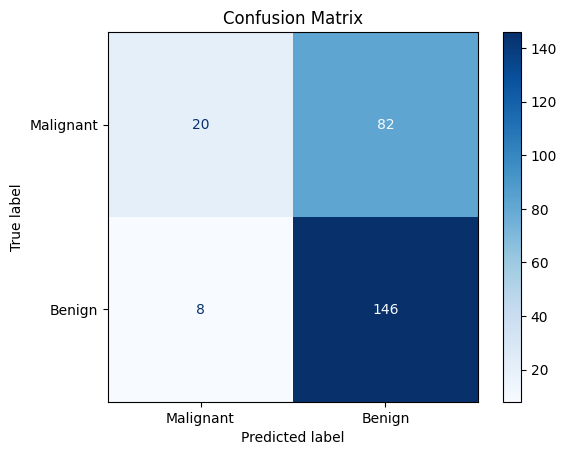

True Positives:  146
True Negatives:  20
False Positives: 82
False Negatives: 8


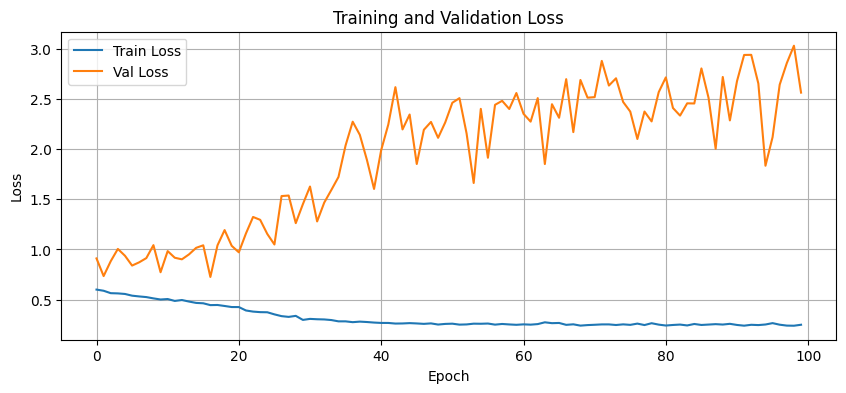

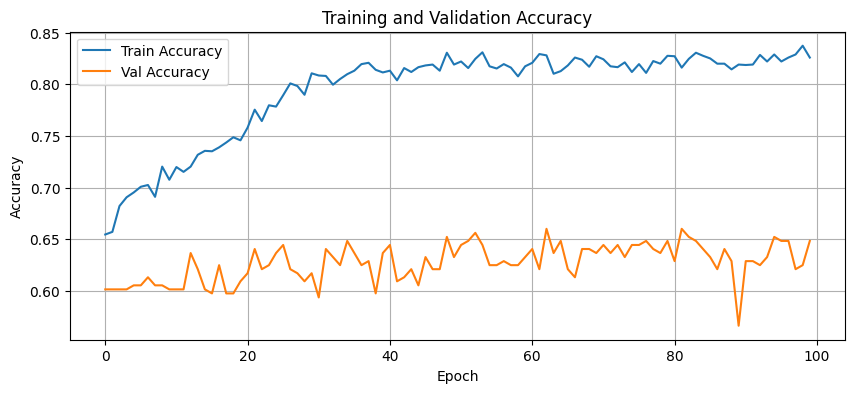

In [ ]:
#GPT help here

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        if val_labels.dim() == 1:
            val_labels = val_labels.unsqueeze(1)
        val_labels = val_labels.float()

        val_outputs = model(val_inputs)
        val_preds = (torch.sigmoid(val_outputs) > 0.5).int()

        all_preds.extend(val_preds.cpu().numpy())
        all_targets.extend(val_labels.int().cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Malignant", "Benign"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
    print(f"True Positives:  {tp}")
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
else:
    print("Warning: Confusion matrix is not 2x2. Got shape:", cm.shape)

plt.figure(figsize=(10, 4))
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
target_names = ["Malignant (0)", "Benign (1)"]
print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))

Classification Report:

               precision    recall  f1-score   support

Malignant (0)     0.7143    0.1961    0.3077       102
   Benign (1)     0.6404    0.9481    0.7644       154

     accuracy                         0.6484       256
    macro avg     0.6773    0.5721    0.5360       256
 weighted avg     0.6698    0.6484    0.5824       256



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)

print(f"Precision (Benign class): {precision:.4f}")
print(f"Recall (Benign class):    {recall:.4f}")
print(f"F1 Score (Benign class):  {f1:.4f}")


Precision (Benign class): 0.6404
Recall (Benign class):    0.9481
F1 Score (Benign class):  0.7644


Big data train  
epochs 30:  
full egypt on poland 63.5%    
egypt 1180 on poland 62.27%     
egypt 2360 on poland    

Egypt train and Egypt test 83.0%  
Adam:  
egypt all train poland test   62.58%  
egypt all mixed poland test  61.88%  
egypt 100 train egypt test 76.4%      
egypt 100 train poland test 63.6%  
egypt 100 train + 25 synth poland test 65%  
egypt 100 train + 50 synth poland test 65%  
egypt 100 train + 75 synth poland test 65.4%  
egypt 100 train + 100 synth poland test 65%  

